### Dogs classification
Data taken from [here](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Dataset is represented by 50 dog breed classes, which can be found in the train folder in their respective directories.


In [ ]:
# download the data
!wget -O data.zip https://uc4c23f10f6878dfa03af1e4792d.dl.dropboxusercontent.com/cd/0/get/BcN-BUYmaUMMfnqqVRT6h30XzPsTYg2HiQAG2Ox2l_VypIBMi8i43L6vFQvgOrapN9uA_w1GjSFgeRcr4QLIBOOWaIRmkE5pNoWFnnz3m0fYCtiqaqp_rCSeQ3qDqgHgS-4Ia-yaVJE8qZOdP5_I1Prx/file?_download_id=703349452107206872197167703757647463645580213429206596159903498&_notify_domain=www.dropbox.com&dl=1

--2021-12-20 15:12:22--  https://uc4c23f10f6878dfa03af1e4792d.dl.dropboxusercontent.com/cd/0/get/BcN-BUYmaUMMfnqqVRT6h30XzPsTYg2HiQAG2Ox2l_VypIBMi8i43L6vFQvgOrapN9uA_w1GjSFgeRcr4QLIBOOWaIRmkE5pNoWFnnz3m0fYCtiqaqp_rCSeQ3qDqgHgS-4Ia-yaVJE8qZOdP5_I1Prx/file?_download_id=703349452107206872197167703757647463645580213429206596159903498
Resolving uc4c23f10f6878dfa03af1e4792d.dl.dropboxusercontent.com (uc4c23f10f6878dfa03af1e4792d.dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to uc4c23f10f6878dfa03af1e4792d.dl.dropboxusercontent.com (uc4c23f10f6878dfa03af1e4792d.dl.dropboxusercontent.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333162777 (318M) [application/binary]
Saving to: ‘data.zip’

data.zip            100%[===================>] 317.73M  87.3MB/s    in 3.8s    

2021-12-20 15:12:27 (84.3 MB/s) - ‘data.zip’ saved [333162777/333162777]



In [ ]:
!unzip /content/data.zip

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Dec 20 15:12:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, datasets, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler


from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [ ]:
class DogsDataset(Dataset):
    """
    Dataset with pictures, which loads them from folders,
    scales and turns to torch tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        # x = transform(x)
        if self.mode == 'test':
            x = transform(x)
            return x
        elif self.mode == 'train':
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        else:
            x = transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('/content/data/train')
TEST_DIR = Path('/content/data/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpeg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpeg')))

In [ ]:
len(train_val_files), len(test_files)

(7166, 1503)

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = DogsDataset(val_files, mode='val')

In [ ]:
train_labels = [path.parent.name for path in train_files]

Let's see how many pictures of each class ended up in the train_files (looking for imbalance):

In [ ]:
from collections import Counter
c = Counter(train_labels).most_common()[::-1]
c

[('28', 90),
 ('42', 92),
 ('29', 92),
 ('23', 92),
 ('48', 92),
 ('44', 92),
 ('12', 92),
 ('31', 92),
 ('33', 93),
 ('6', 93),
 ('34', 93),
 ('3', 93),
 ('9', 94),
 ('27', 94),
 ('32', 94),
 ('1', 95),
 ('22', 95),
 ('45', 96),
 ('21', 96),
 ('2', 97),
 ('49', 97),
 ('10', 97),
 ('41', 98),
 ('5', 100),
 ('13', 103),
 ('7', 103),
 ('24', 103),
 ('47', 104),
 ('18', 104),
 ('11', 104),
 ('15', 106),
 ('17', 107),
 ('4', 108),
 ('20', 111),
 ('26', 113),
 ('0', 113),
 ('19', 115),
 ('14', 115),
 ('43', 116),
 ('46', 116),
 ('30', 121),
 ('36', 124),
 ('39', 127),
 ('40', 127),
 ('8', 130),
 ('16', 130),
 ('38', 132),
 ('35', 146),
 ('37', 148),
 ('25', 189)]

Seems ok

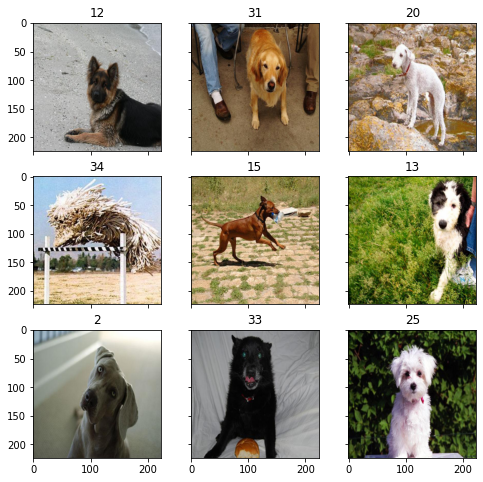

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Let's use a pre-trained network ResNet152

In [ ]:
model = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Experiments have shown that the best results are obtained if the whole network is fine-tuned

num_features = 2048
# Replacing the Fully-Connected layer with our linear classifier
model.fc = nn.Linear(num_features, 50)

model = model.cuda()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, gradient_accumulation = 1):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(train_loader):
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(0.6, 0.6, 0.6, 0),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        inputs = torch.Tensor(inputs.numpy().transpose((0,3,1,2)))
        noise = torch.Tensor(np.random.uniform(0,0.1,(inputs.shape[0],3,224,224)))
        inputs += noise

        for i in range(len(inputs)):
            inputs[i] = train_transform(inputs[i])
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, labels) / gradient_accumulation
        loss.backward()
        if (i+1) % gradient_accumulation == 0:
            optimizer.step()
            optimizer.zero_grad()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, gradient_accumulation = 1):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    best_val_loss = 1000

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr= 0.0001)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, 
                                              opt, gradient_accumulation)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), '/content/drive/MyDrive/deep_learning/ml_mipt_autumn_2021/lab_2_part_5/resnet_152__bs=56__accum=3.pth')
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step()
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
if val_dataset is None:
    val_dataset = DogsDataset(val_files, mode='val')
    
train_dataset = DogsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=30, 
                batch_size=56, gradient_accumulation = 3)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 1.3252071302355024


epoch:   3%|▎         | 1/30 [26:06<12:36:57, 1566.12s/it]


Epoch 001 train_loss: 1.3252     val_loss 3.7276 train_acc 0.0190 val_acc 0.1094
loss 1.240006259484144


epoch:   7%|▋         | 2/30 [35:00<7:27:41, 959.34s/it]


Epoch 002 train_loss: 1.2400     val_loss 3.0509 train_acc 0.1185 val_acc 0.2154
loss 1.0794803129947892


epoch:  10%|█         | 3/30 [43:55<5:44:22, 765.29s/it]


Epoch 003 train_loss: 1.0795     val_loss 3.0792 train_acc 0.1602 val_acc 0.2126
loss 1.0876787696844767


epoch:  13%|█▎        | 4/30 [52:47<4:51:51, 673.51s/it]


Epoch 004 train_loss: 1.0877     val_loss 2.4384 train_acc 0.1654 val_acc 0.4386
loss 0.8592100228170148


epoch:  17%|█▋        | 5/30 [1:01:39<4:19:16, 622.24s/it]


Epoch 005 train_loss: 0.8592     val_loss 1.8511 train_acc 0.4057 val_acc 0.5273
loss 0.6933107258530855


epoch:  20%|██        | 6/30 [1:10:34<3:57:00, 592.53s/it]


Epoch 006 train_loss: 0.6933     val_loss 1.4117 train_acc 0.4836 val_acc 0.6094
loss 0.5467821468994615


epoch:  23%|██▎       | 7/30 [1:19:29<3:39:55, 573.73s/it]


Epoch 007 train_loss: 0.5468     val_loss 1.0039 train_acc 0.5553 val_acc 0.7065
loss 0.4233329152036077


epoch:  27%|██▋       | 8/30 [1:28:21<3:25:31, 560.54s/it]


Epoch 008 train_loss: 0.4233     val_loss 0.9242 train_acc 0.6468 val_acc 0.7366
loss 0.38561849240081925


epoch:  30%|███       | 9/30 [1:37:13<3:13:06, 551.74s/it]


Epoch 009 train_loss: 0.3856     val_loss 0.8169 train_acc 0.6678 val_acc 0.7589
loss 0.29376820959830136


epoch:  33%|███▎      | 10/30 [1:46:06<3:01:55, 545.79s/it]


Epoch 010 train_loss: 0.2938     val_loss 0.7167 train_acc 0.7350 val_acc 0.7840
loss 0.25297462469944954


epoch:  37%|███▋      | 11/30 [1:54:59<2:51:35, 541.89s/it]


Epoch 011 train_loss: 0.2530     val_loss 0.6336 train_acc 0.7709 val_acc 0.7974
loss 0.24180603322926889


epoch:  40%|████      | 12/30 [2:03:55<2:42:00, 540.05s/it]


Epoch 012 train_loss: 0.2418     val_loss 0.5398 train_acc 0.7815 val_acc 0.8359
loss 0.2079986115348441


epoch:  43%|████▎     | 13/30 [2:12:49<2:32:33, 538.43s/it]


Epoch 013 train_loss: 0.2080     val_loss 0.5029 train_acc 0.8171 val_acc 0.8415
loss 0.1819725802974449


epoch:  47%|████▋     | 14/30 [2:21:39<2:22:50, 535.65s/it]


Epoch 014 train_loss: 0.1820     val_loss 0.4767 train_acc 0.8346 val_acc 0.8488
loss 0.16243047091678744


epoch:  50%|█████     | 15/30 [2:30:29<2:13:30, 534.06s/it]


Epoch 015 train_loss: 0.1624     val_loss 0.4307 train_acc 0.8560 val_acc 0.8711
loss 0.14507162176934946


epoch:  53%|█████▎    | 16/30 [2:39:20<2:04:23, 533.08s/it]


Epoch 016 train_loss: 0.1451     val_loss 0.4244 train_acc 0.8688 val_acc 0.8666
loss 0.136532435718415


epoch:  57%|█████▋    | 17/30 [2:48:10<1:55:17, 532.10s/it]


Epoch 017 train_loss: 0.1365     val_loss 0.4119 train_acc 0.8731 val_acc 0.8655
loss 0.12385726949407302


epoch:  60%|██████    | 18/30 [2:56:59<1:46:14, 531.23s/it]


Epoch 018 train_loss: 0.1239     val_loss 0.4174 train_acc 0.8841 val_acc 0.8700
loss 0.11894993781267066


epoch:  63%|██████▎   | 19/30 [3:05:48<1:37:16, 530.60s/it]


Epoch 019 train_loss: 0.1189     val_loss 0.4251 train_acc 0.8848 val_acc 0.8689
loss 0.10180720495033051


epoch:  67%|██████▋   | 20/30 [3:14:39<1:28:26, 530.69s/it]


Epoch 020 train_loss: 0.1018     val_loss 0.4065 train_acc 0.9032 val_acc 0.8806
loss 0.08974980338603801


epoch:  70%|███████   | 21/30 [3:23:28<1:19:31, 530.21s/it]


Epoch 021 train_loss: 0.0897     val_loss 0.3945 train_acc 0.9168 val_acc 0.8823
loss 0.0829563932704757


epoch:  73%|███████▎  | 22/30 [3:32:20<1:10:47, 530.91s/it]


Epoch 022 train_loss: 0.0830     val_loss 0.3845 train_acc 0.9218 val_acc 0.8823
loss 0.07530483108250945


epoch:  77%|███████▋  | 23/30 [3:41:14<1:02:02, 531.73s/it]


Epoch 023 train_loss: 0.0753     val_loss 0.3753 train_acc 0.9269 val_acc 0.8890
loss 0.06606623538429071


epoch:  80%|████████  | 24/30 [3:50:08<53:13, 532.23s/it]


Epoch 024 train_loss: 0.0661     val_loss 0.3620 train_acc 0.9371 val_acc 0.8923
loss 0.06343997061629698


epoch:  83%|████████▎ | 25/30 [3:59:10<44:36, 535.26s/it]


Epoch 025 train_loss: 0.0634     val_loss 0.3519 train_acc 0.9392 val_acc 0.8917
loss 0.05673503459046155


epoch:  87%|████████▋ | 26/30 [4:08:10<35:47, 536.85s/it]


Epoch 026 train_loss: 0.0567     val_loss 0.3568 train_acc 0.9459 val_acc 0.8901
loss 0.05155632688217129


epoch:  90%|█████████ | 27/30 [4:17:11<26:54, 538.13s/it]


Epoch 027 train_loss: 0.0516     val_loss 0.3731 train_acc 0.9548 val_acc 0.8940
loss 0.04236039275197422


epoch:  93%|█████████▎| 28/30 [4:26:12<17:57, 538.88s/it]


Epoch 028 train_loss: 0.0424     val_loss 0.3935 train_acc 0.9609 val_acc 0.8890
loss 0.03436985389950952


epoch:  97%|█████████▋| 29/30 [4:35:14<08:59, 539.63s/it]


Epoch 029 train_loss: 0.0344     val_loss 0.4099 train_acc 0.9708 val_acc 0.8811
loss 0.031177030924803315


epoch: 100%|██████████| 30/30 [4:44:31<00:00, 569.05s/it]


Epoch 030 train_loss: 0.0312     val_loss 0.4321 train_acc 0.9723 val_acc 0.8839


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

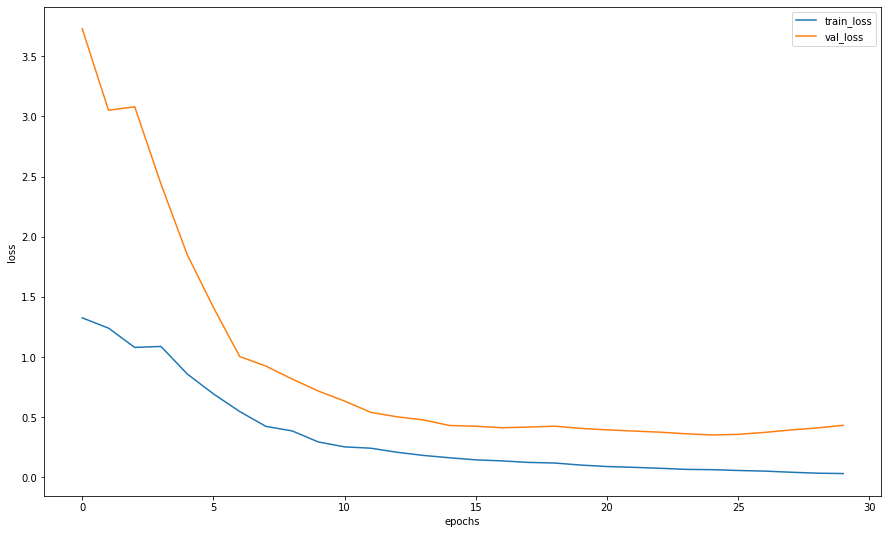

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()
val_loader = DataLoader(val_dataset, batch_size=56, shuffle=False)
model.eval()
eval_epoch(model, val_loader, criterion)

(0.4321012042928487, tensor(0.8839, device='cuda:0', dtype=torch.float64))

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/deep_learning/ml_mipt_autumn_2021/lab_2_part_5/resnet_152__bs=56__accum=3__end_training.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/deep_learning/ml_mipt_autumn_2021/lab_2_part_5/resnet_152__bs=56__accum=3.pth'))

<All keys matched successfully>

In [ ]:
model.eval()
eval_epoch(model, val_loader, criterion)

(0.35189653001725674, tensor(0.8917, device='cuda:0', dtype=torch.float64))

In [ ]:
test_dataset = DogsDataset(test_files, mode="test")
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
def change_file_name(name, num_digits=10):
    n = num_digits - len(name) + 5 # for jpeg
    return '0'*n + name


In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'FileName': test_filenames, 'Prediction': preds})
my_submit['sort_val'] = my_submit['FileName'].apply(lambda x: change_file_name(x))
my_submit = my_submit.sort_values('sort_val').drop('sort_val', 1)
my_submit = my_submit.reset_index().drop('index', 1)
my_submit.head(6)

,FileName,Prediction
0,0.jpeg,42
1,1.jpeg,3
2,2.jpeg,14
3,3.jpeg,14
4,4.jpeg,39
5,5.jpeg,14


In [ ]:
my_submit.shape

(1503, 2)

In [ ]:
my_submit.to_csv('dogs_classification_submission.csv', index=False)